In [1]:
!pwd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.executable

/c/Users/81908/jupyter_notebook/tf_2_work/tf_work


'C:\\Users\\81908\\Anaconda3\\envs\\tfgpu\\python.exe'

# TensorFlow org サイトの TF 2.0 – Advanced Tutorials – Images の以下のページを翻訳
- http://tensorflow.classcat.com/2019/11/04/tf20-tutorials-images-classification/

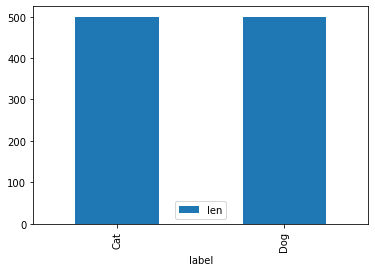

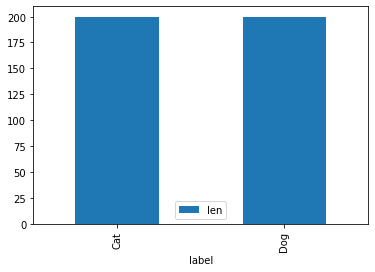

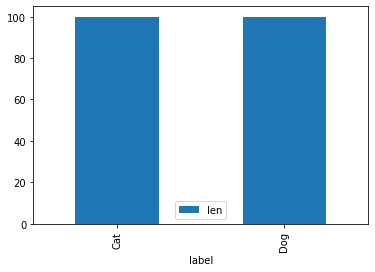

In [2]:
import os
import glob
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
VALID_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
TEST_DIR = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

def plot_jpg_len(_dir):
    """指定ディレクトリのjpgファイルの数を棒グラフで可視化"""
    label_dir_paths = sorted(glob.glob(str(pathlib.Path(_dir) / '*')))
    len_label_paths = [len(glob.glob(p + '/*jpg')) for p in label_dir_paths]
    df = pd.DataFrame({'label':[pathlib.Path(p).name for p in label_dir_paths], 
                       'len':len_label_paths})
    df = df.set_index('label')
    df.plot.bar()
    plt.show()
    
    total_len = df['len'].sum()
    return total_len
    
total_train = plot_jpg_len(TRAIN_DIR)
total_valid = plot_jpg_len(VALID_DIR)
total_test = plot_jpg_len(TEST_DIR)

In [3]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=TRAIN_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

valid_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                                directory=VALID_DIR,
                                                                shuffle=False,
                                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                                class_mode='binary')

Found 1000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


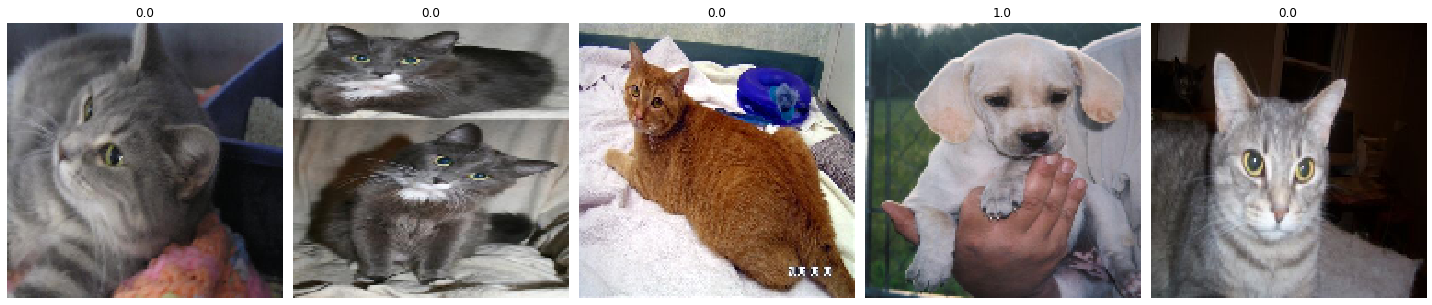

In [4]:
def plot_images(images_arr: np.ndarray, y_onehots: np.ndarray):
    """
    ラベルをタイトルにしてnumpyの画像を並べて表示
    Args:
        images_arr:[5,hight,width,3]のnumpy画像
        y_onehots:[5,n]のラベル
    Usage:
        train_image_generator = ImageDataGenerator(rescale=1./255)
        train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,…)
        sample_training_images, y_onehots = next(train_data_gen)
        plot_images(sample_training_images[:5], y_onehots)
    """
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, y, ax in zip (images_arr, y_onehots, axes):
        ax.imshow(img)
        ax.set_title(y)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
sample_training_images, y_onehots = next(train_data_gen)
plot_images(sample_training_images[:5], y_onehots)

In [5]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(16, 3, padding='same', activation='relu')
        self.conv2 = Conv2D(32, 3, padding='same', activation='relu')
        self.conv3 = Conv2D(64, 3, padding='same', activation='relu')
        self.pooling = MaxPooling2D()
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
        self.dense_out = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense_out(x)

# モデルのインスタンスを作成
model = MyModel()

def get_functional_model(model, input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)):
    """
    model.summary()でエラー避けるため、インスタンス化した「仮のモデル」をFunctional APIで生成する独自関数
    https://www.atmarkit.co.jp/ait/articles/2003/10/news016.html
    
    以下の書き方でもmodel.summary()出せるが、Output Shapeが表示されない
    model = MyModel()
    model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH ,3))  # モデルのビルド
    model.summary()
    """
    x = tf.keras.layers.Input(shape=input_shape, name='layer_in')
    temp_model = tf.keras.Model(
        inputs=[x],
        outputs=model.call(x),  # ※サブクラス化したモデルの`call`メソッドを指定
        name='temp_model')  # 仮モデルにも名前付け
    return temp_model

f_model = get_functional_model(model)
f_model.summary()

Model: "temp_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
layer_in (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 16) 448         layer_in[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    multiple             0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
_________________________________________________________________________________________

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=valid_data_gen,
)

  ...
    to  
  ['...']
Train for 8 steps, validate for 4 steps
Epoch 1/15
8/8 [==============================] - 5s 613ms/step - loss: 1.3105 - accuracy: 0.4860 - val_loss: 0.6755 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 3s 354ms/step - loss: 0.6905 - accuracy: 0.5110 - val_loss: 0.6859 - val_accuracy: 0.5125
Epoch 3/15
8/8 [==============================] - 3s 333ms/step - loss: 0.6849 - accuracy: 0.5150 - val_loss: 0.6791 - val_accuracy: 0.6425
Epoch 4/15
8/8 [==============================] - 3s 337ms/step - loss: 0.6708 - accuracy: 0.5960 - val_loss: 0.6452 - val_accuracy: 0.5475
Epoch 5/15
8/8 [==============================] - 3s 363ms/step - loss: 0.6452 - accuracy: 0.6560 - val_loss: 0.6174 - val_accuracy: 0.6325
Epoch 6/15
8/8 [==============================] - 3s 346ms/step - loss: 0.6054 - accuracy: 0.7020 - val_loss: 0.6261 - val_accuracy: 0.6225
Epoch 7/15
8/8 [==============================] - 3s 324ms/step - loss: 0.5712 - accuracy: 0.69

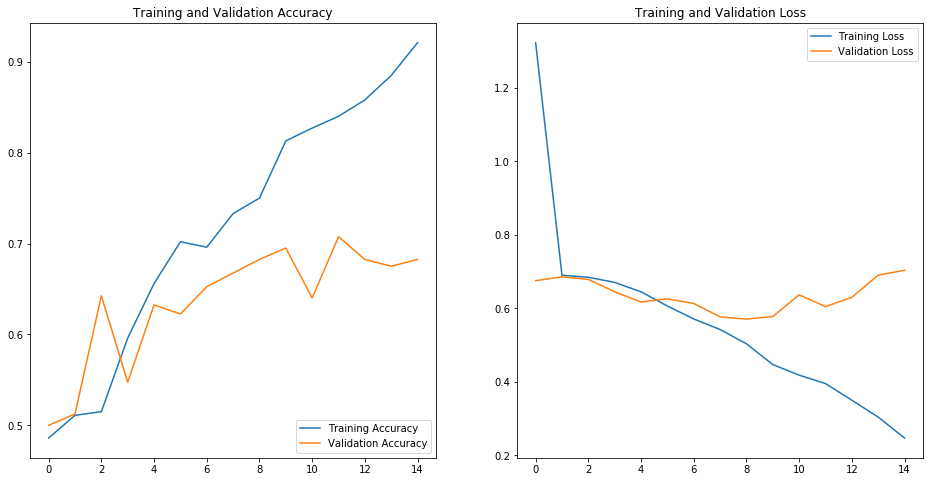

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(epochs)
 
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 画像水増しして過学習抑える

Found 1000 images belonging to 2 classes.


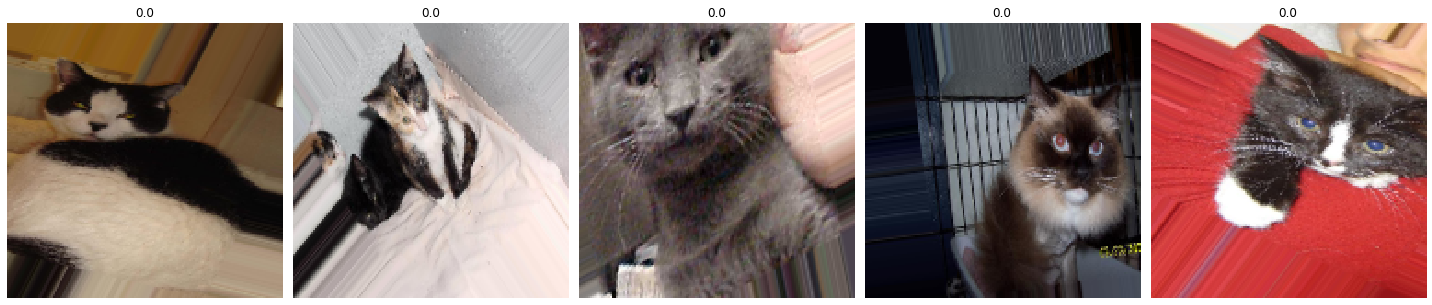

  ...
    to  
  ['...']
Train for 8 steps, validate for 4 steps
Epoch 1/15
8/8 [==============================] - 8s 940ms/step - loss: 0.9387 - accuracy: 0.5130 - val_loss: 0.6623 - val_accuracy: 0.5000
Epoch 2/15
8/8 [==============================] - 7s 846ms/step - loss: 0.6918 - accuracy: 0.5070 - val_loss: 0.6650 - val_accuracy: 0.5050
Epoch 3/15
8/8 [==============================] - 6s 791ms/step - loss: 0.6808 - accuracy: 0.5460 - val_loss: 0.6670 - val_accuracy: 0.5625
Epoch 4/15
8/8 [==============================] - 6s 794ms/step - loss: 0.6901 - accuracy: 0.5480 - val_loss: 0.6892 - val_accuracy: 0.5775
Epoch 5/15
8/8 [==============================] - 6s 792ms/step - loss: 0.6889 - accuracy: 0.5230 - val_loss: 0.6959 - val_accuracy: 0.5475
Epoch 6/15
8/8 [==============================] - 6s 801ms/step - loss: 0.6881 - accuracy: 0.5350 - val_loss: 0.6782 - val_accuracy: 0.6025
Epoch 7/15
8/8 [==============================] - 6s 784ms/step - loss: 0.6768 - accuracy: 0.56

In [8]:
image_gen = ImageDataGenerator(rescale=1./255, 
                               width_shift_range=.15,
                               height_shift_range=.15,
                               horizontal_flip=True, 
                               rotation_range=45, 
                               zoom_range=0.5, 
                              )
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=TRAIN_DIR,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='binary')
sample_training_images, y_onehots = next(train_data_gen)
plot_images(sample_training_images[:5], y_onehots)

model = MyModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=valid_data_gen,
)

## モデルにDropout追加する

In [9]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(16, 3, padding='same', activation='relu')
        self.conv2 = Conv2D(32, 3, padding='same', activation='relu')
        self.conv3 = Conv2D(64, 3, padding='same', activation='relu')
        self.pooling = MaxPooling2D()
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
        self.dense_out = Dense(1, activation='sigmoid')
        self.drop = Dropout(0.2)

    def call(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.drop(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense_out(x)

# モデルのインスタンスを作成
model = MyModel()

def get_functional_model(model, input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)):
    """
    model.summary()でエラー避けるため、インスタンス化した「仮のモデル」をFunctional APIで生成する独自関数
    https://www.atmarkit.co.jp/ait/articles/2003/10/news016.html
    
    以下の書き方でもmodel.summary()出せるが、Output Shapeが表示されない
    model = MyModel()
    model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH ,3))  # モデルのビルド
    model.summary()
    """
    x = tf.keras.layers.Input(shape=input_shape, name='layer_in')
    temp_model = tf.keras.Model(
        inputs=[x],
        outputs=model.call(x),  # ※サブクラス化したモデルの`call`メソッドを指定
        name='temp_model')  # 仮モデルにも名前付け
    return temp_model

f_model = get_functional_model(model)
f_model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=valid_data_gen,
)

Model: "temp_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
layer_in (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 150, 150, 16) 448         layer_in[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  multiple             0           conv2d_6[0][0]                   
                                                                 conv2d_7[0][0]                   
                                                                 conv2d_8[0][0]                   
_________________________________________________________________________________________

## finetuning

In [10]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None,)
        self.pooling = MaxPooling2D()
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
        self.dense_out = Dense(1, activation='sigmoid')
        self.drop = Dropout(0.2)

    def call(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense_out(x)

# モデルのインスタンスを作成
model = MyModel()

def get_functional_model(model, input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)):
    """
    model.summary()でエラー避けるため、インスタンス化した「仮のモデル」をFunctional APIで生成する独自関数
    https://www.atmarkit.co.jp/ait/articles/2003/10/news016.html
    
    以下の書き方でもmodel.summary()出せるが、Output Shapeが表示されない
    model = MyModel()
    model.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH ,3))  # モデルのビルド
    model.summary()
    """
    x = tf.keras.layers.Input(shape=input_shape, name='layer_in')
    temp_model = tf.keras.Model(
        inputs=[x],
        outputs=model.call(x),  # ※サブクラス化したモデルの`call`メソッドを指定
        name='temp_model')  # 仮モデルにも名前付け
    return temp_model

f_model = get_functional_model(model)
f_model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=valid_data_gen,
)

Model: "temp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_in (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 18,910,017
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
Train for 8 steps, validate for 4 steps
Epoch 1/15
8/8 [=============================

## 自作のgeneratorでtrain

Found 1000 images belonging to 2 classes.
(128,)


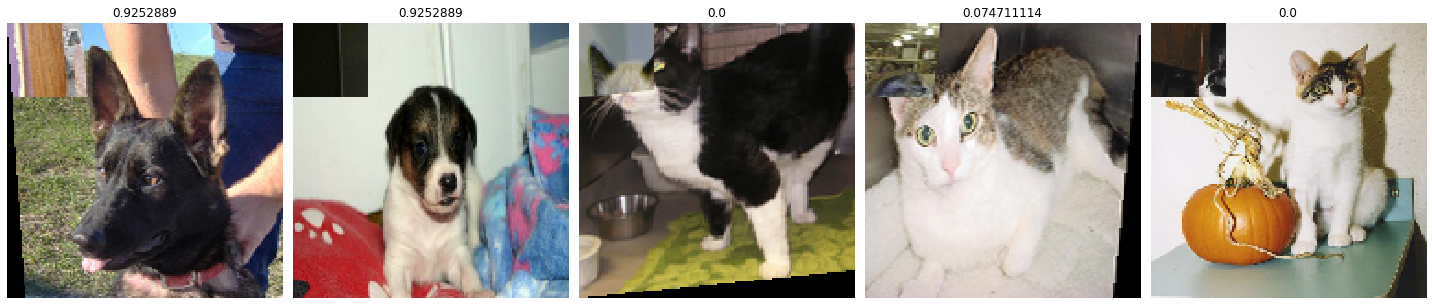

  ...
    to  
  ['...']
Train for 7 steps, validate for 4 steps
Epoch 1/15
7/7 [==============================] - 7s 1s/step - loss: 20.3500 - accuracy: 0.2603 - val_loss: 0.7520 - val_accuracy: 0.5000
Epoch 2/15
7/7 [==============================] - 5s 680ms/step - loss: 1.0868 - accuracy: 0.2594 - val_loss: 0.6893 - val_accuracy: 0.5525
Epoch 3/15
7/7 [==============================] - 5s 688ms/step - loss: 0.7141 - accuracy: 0.2523 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 4/15
7/7 [==============================] - 5s 678ms/step - loss: 0.6934 - accuracy: 0.2465 - val_loss: 0.6875 - val_accuracy: 0.5000
Epoch 5/15
7/7 [==============================] - 5s 681ms/step - loss: 0.6933 - accuracy: 0.2441 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 6/15
7/7 [==============================] - 5s 682ms/step - loss: 0.7278 - accuracy: 0.2370 - val_loss: 0.6881 - val_accuracy: 0.5000
Epoch 7/15
7/7 [==============================] - 5s 688ms/step - loss: 0.6935 - accuracy: 0.2489

In [11]:
import sys
sys.path.append(r'C:\Users\81908\jupyter_notebook\tfgpu_py36_work\02_keras_py\transformer')
import tf_my_generator

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=TRAIN_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

# 自作のgeneratorでラップ
custom_gen = tf_my_generator.cutmix_generator(train_data_gen)
custom_gen = tf_my_generator.randaugment_generator(custom_gen, N=3, M=4)

sample_training_images, y_onehots = next(custom_gen)
print(y_onehots.shape)
plot_images(sample_training_images[:5], y_onehots)

model = MyModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    custom_gen,
    steps_per_epoch=total_train // batch_size,  # 自作のImageDataGeneratorの場合はsteps_per_epoch指定必要
    epochs=epochs,
    validation_data=valid_data_gen,
)

## 予測

Found 200 images belonging to 2 classes.


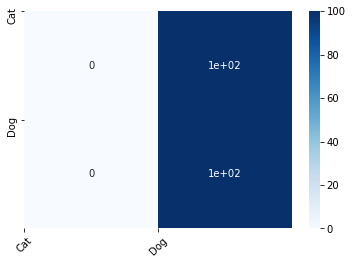

In [12]:
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=TEST_DIR,
                                                         shuffle=False,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                        )
y_true = ["cat" if y < 0.5 else "dog" for y in test_data_gen.classes]
y_pred = ["cat" if pb < 0.5 else "dog" for pb in model.predict(test_data_gen).reshape(-1)]

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xticks(np.arange(2), ['Cat', 'Dog'], rotation=45)
plt.yticks(np.arange(2), ['Cat', 'Dog'])
plt.show()